In [1]:
using HDF5; h5 = HDF5
using PyPlot; plt = PyPlot

#fid = h5.h5open("gf_ysr.order2_ntau1024_N_samples4096_N_seqs4.h5", "r")
#fid = h5.h5open("gf_ysr.order2_ntau1024_N_samples16384_N_seqs4.h5", "r")
#fid = h5.h5open("gf_ysr.order2_ntau1024_N_samples65536_N_seqs4.h5", "r")
fid = h5.h5open("gf_ysr.order2_ntau1024_N_samples262144_N_seqs4.h5", "r")

τ = fid["/data/tau"][]
β = τ[end]

orders = fid["/data/orders"][]
@show orders

g_u1 = imag(fid["/data/gf/up_11"][]);
g_d1 = imag(fid["/data/gf/dn_11"][]);
g_u2 = imag(fid["/data/gf/up_22"][]);
g_d2 = imag(fid["/data/gf/dn_22"][]);

g_std_u1 = fid["/data/gf_std/up_11"][];
g_std_d1 = fid["/data/gf_std/dn_11"][];
g_std_u2 = fid["/data/gf_std/up_22"][];
g_std_d2 = fid["/data/gf_std/dn_22"][];

orders = [0, 1, 2]


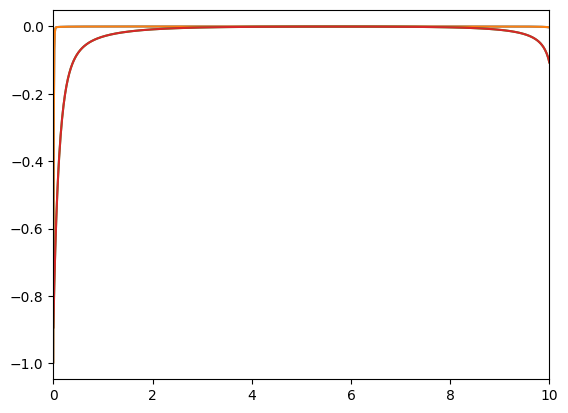

In [2]:
plt.plot(τ, g_u1, label=raw"$\uparrow,1$")
plt.plot(τ, g_d1, label=raw"$\donwarrow,1$")
plt.plot(τ, g_u2, label=raw"$\uparrow,2$")
plt.plot(τ, g_d2, label=raw"$\downarrow,2$")
plt.xlim((0, β));

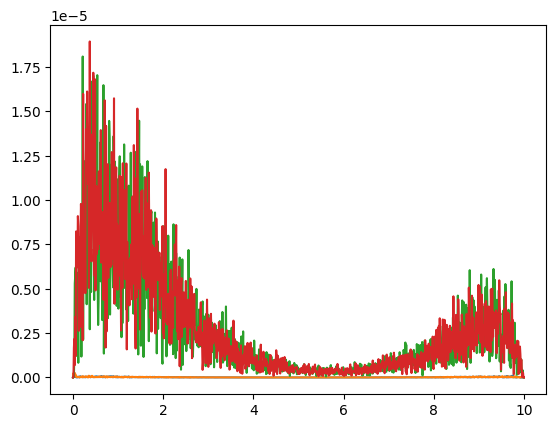

In [3]:
plt.plot(τ, real(g_std_u1), label=raw"$\uparrow,1$");
plt.plot(τ, real(g_std_d1), label=raw"$\donwarrow,1$");
plt.plot(τ, real(g_std_u2), label=raw"$\uparrow,2$");
plt.plot(τ, real(g_std_d2), label=raw"$\downarrow,2$");

# Gregory integration

In [4]:
raw"""
Compute a list of Gregory coefficients G_1, G_2, ..., G_{n_max}
using a recurrence formula

\frac{G_1}{n} - \frac{G_2}{n-1} + \frac{G_3}{n-2} - ... +
    + (-1)^{n-1}\frac{G_n}{1} = \frac{1}{n+1}.
"""
function gregory_coefficients(n_max)
    @assert n_max >= 1

    G = [0.5]
    for n in 2:n_max
        s = sum((-1) ^ (i - 1) / (n + 1 - i) * G[i] for i in 1:(n - 1))
        G_n = (-1) ^ (n - 1) * (1 / (n + 1) - s)
        push!(G, G_n)
    end

    return G
end

"Returns weights for Gregory integration"
function gregory_weights(n, order)
    stencil_size = order + 1
    @assert n > stencil_size

    # Trapezoid rule contribution
    w = ones(Float64, n)
    w[1] = w[end] = 0.5

    # Gregory boundary corrections
    if order > 0
        G = gregory_coefficients(order + 1)
        B = [sum(G[r] * (-1) ^ (r - i) * binomial(r - 1, i) for r in 2:(order + 1)) for i in 0:order]
        w[1:stencil_size] += B
        w[end-stencil_size+1:end] += B[end:-1:1]
    end
    
    return w
end

gregory_weights

# Fourier transform

In [5]:
function fourier(τ_list, g_τ, n_ω; order = 5)
    β = τ_list[end]
    h = τ_list[2] - τ_list[1]
    w = gregory_weights(length(τ_list), order)
    mat = h * [exp(1im * π * (2n + 1) * (τ / β)) * w[j]
               for n in -n_ω:(n_ω-1), (j, τ) in enumerate(τ_list)]
    return mat * g_τ
end

fourier (generic function with 1 method)

# Analytic continuation

In [6]:
using BaryRational

"Norm of a spectral function"
function dos_norm(ϵ_list, ρ; gregory_order = 5)
    w = gregory_weights(length(ϵ_list), gregory_order)
    return step(ϵ_list) * sum(w .* ρ)
end

function cont(τ_list, g_τ, n_iω, ϵ_list, δ; gregory_order = 5)
    println("Discontinous jump: $(-g_τ[1]-g_τ[end])")
    β = τ_list[end]
    
    iω = 1im * [π * (2n + 1) / β for n in -n_iω:(n_iω-1)]
    g_iω = fourier(τ_list, g_τ, n_iω, order=gregory_order)

    ga = aaa(iω, g_iω)

    ϵ = complex.(collect(ϵ_list))
    ρ = [-(1 / π) * imag(ga(ϵ .+ 1im * δ)) for ϵ in ϵ_list]
    println("DOS norm: ", dos_norm(ϵ_list, ρ, gregory_order=gregory_order))

    return ρ
end

cont (generic function with 1 method)

Discontinous jump: 0.9999999999999999
DOS norm: 0.9926750607696251


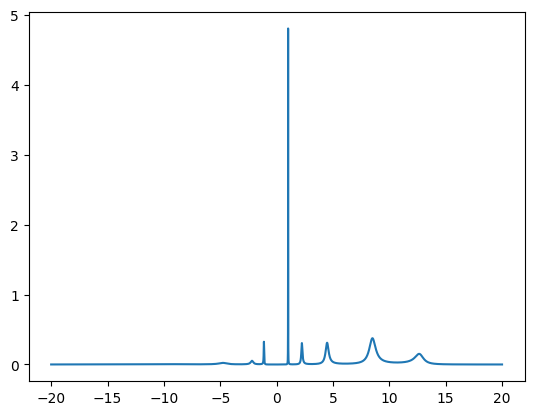

In [7]:
n_iω = 128
ϵ_list = -20:0.0001:20
δ = 0.001

ρ = cont(τ, g_u2, n_iω, ϵ_list, δ, gregory_order=3)

plt.plot(ϵ_list, ρ);